In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

import os
import sys
import subprocess
import pandas as pd
import seaborn as sb

import matplotlib.backends.backend_pdf
from datetime import datetime

#Fecha actual
ahora = str(datetime.now()).split(' ') 
fecha = ahora[0] 

print('Última modificacion: %s' %fecha)

lw=2
fz=15

Última modificacion: 2021-09-21


## Camino de los datos:

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b327_data/Amplitude_Candidates/Amplitude_candidates_b327.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b327_data/eta_Candidates/eta_Candidates_b327.cat

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b328_data/Amplitude_Candidates/Amplitude_candidates_b328.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b328_data/eta_Candidates/eta_Candidates_b328.cat

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b329_data/Amplitude_Candidates/Amplitude_candidates_b329.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b329_data/eta_Candidates/eta_Candidates_b329.cat


/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b341_data/Amplitude_Candidates/Amplitude_candidates_b341.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b341_data/eta_Candidates/eta_Candidates_b341.cat

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b342_data/Amplitude_Candidates/Amplitude_candidates_b342.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b342_data/eta_Candidates/eta_Candidates_b342.cat

/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/b343_data/Amplitude_Candidates/Amplitude_candidates_b343.cat
/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/b343_data/eta_Candidates/eta_Candidates_b343.cat

Primero, escribiremos lo que quiero lograr con esto:

- [x] Visualizar los datos de las regiones de formación estelar 3 que hemos conseguido.
- [x] Unir las series de tiempo que están superpuestas.
- [x] Crear el plot de amplitud
- [x] calcular los indices con incerteza usando bootstrap y comparar en regresion lineal
- [ ] Colores con catálogo VIVA.
- [ ] Hacer un proceso para crear un catálogo de estrellas periodicas encontradas e identificadas con IP metric.
- [ ] Juntar estrellas variables GLS con las IP usando los mismos índices y sus incertezas.
- [ ] FIN


## Camino del catálogo generado en TopCat:
/Users/nicomedinap/Documentos_locales/PhD_TESIS/Catalogos/Irregular_catalog_SFR3_21Sep2021.csv

## Catalogo de fuentes que están superpuestos en diferentes tiles:
/Users/nicomedinap/Documentos_locales/PhD_TESIS/Catalogos/Irregular_catalog_SFR3_superposed_21Sep2021.csv


In [88]:
def ReadCords(Ra,Dec,gal=True,Ndecimales=7):
    """
    Devuelve las coordenadas 2000 en longuitudo y latitud galactica.
    """
    
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    import numpy as np

    if gal == True:
        c = SkyCoord(np.array(Ra)*u.degree, np.array(Dec)*u.degree)
        cc = c.galactic
        l_aux = cc.l.degree
        b_aux = cc.b.degree
        
        l = np.array([round(l_aux[i],Ndecimales) for i in range(len(l_aux))])
        b = np.array([round(b_aux[i],Ndecimales) for i in range(len(b_aux))])
        return l,b
    
    return Ra,Dec

def nbins(X):
    """
    Taken from http://toyoizumilab.brain.riken.jp/hideaki/res/histogram.html
    """
    import numpy as np

    x_max = np.max(X)
    x_min = np.min(X)
    N_MIN = 5  #Minimum number of bins (integer)
               #N_MIN must be more than 1 (N_MIN > 1).
    N_MAX = 100  #Maximum number of bins (integer)
    N = range(N_MIN,N_MAX) # #of Bins
    N = np.array(N)
    D = (x_max-x_min)/N    #Bin size vector
    C = np.zeros((len(D),1))

    #Computation of the cost function
    for i in range(np.size(N)):
        edges = np.linspace(x_min,x_max,N[i]+1) # Bin edges
        ki = np.histogram(X,edges) # Count # of events in bins
        ki = ki[0]    
        k = np.mean(ki) #Mean of event count
        v = sum((ki-k)**2)/N[i] #Variance of event count
        C[i] = (2*k-v)/((D[i])**2) #The cost Function
    #Optimal Bin Size Selection
    cmin = min(C)
    idx  = np.where(C==cmin)
    
    #print idx

    try:
        idx = int(idx[0])
    except TypeError:
        idx = 10
        return 10

    #print idx

    optD = D[idx]

    edges = np.linspace(x_min,x_max,N[idx]+1)
    #plt.hist(X,edges, normed=True)
    #title(u"Histogram")
    #ylabel(u"Frequency")
    #xlabel(u"Value")
    return len(edges)-1

def DKs_bootstrap(mag,iteraciones=1000,porcentaje=0.5,show_hist=False):
    """
    Realiza la medición de la amplitud, y estima el error usando bootstrap.
    Entrada:
    iteraciones: Repeticiones del bootstrap.
    porcentaje: % de datos que se retiran de la muestra para hacer el cálculo.
    retorna; MeanKs, error
    """
    import matplotlib.pylab as plt
    import numpy as np
    from random import sample

    N = len(mag)-1

    bootstrap = np.zeros(iteraciones)

    #Porcentaje de datos a retirar de la muestra
    porcent = int(len(mag)*porcentaje)

    for i in range(iteraciones):
        #Sample toma N2-porcent numeros random de mag, así creamos nuestra muestra por bootstrap.
        MAG = sample(list(mag),N-porcent)
        bootstrap[i] = max(MAG)-min(MAG)

    mean = np.mean(bootstrap)
    std  = np.std(bootstrap,ddof=1)

    if show_hist==True:
        plt.hist(bootstrap)
        plt.show()

    return mean,std

def MeanKs_bootstrap(mag,iteraciones=1000,porcentaje=0.1,show_hist=False):
    """
    Realiza la medición de la magnitud media, y estima el error usando bootstrap.
    Entrada:
    iteraciones: Repeticiones del bootstrap.
    porcentaje: % de datos que se retiran de la muestra para hacer el cálculo.
    retorna; MeanKs, error
    """
    import matplotlib.pylab as plt
    import numpy as np
    from random import sample

    N = len(mag)-1

    bootstrap = np.zeros(iteraciones)

    #Porcentaje de datos a retirar de la muestra
    porcent = int(len(mag)*porcentaje)

    for i in range(iteraciones):
        #Sample toma N2-porcent numeros random de mag, así creamos nuestra muestra por bootstrap.
        MAG = sample(list(mag),N-porcent)
        bootstrap[i] = np.mean(MAG)

    mean = np.mean(bootstrap)
    std  = np.std(bootstrap,ddof=1)

    if show_hist==True:
        plt.hist(bootstrap)
        plt.show()

    return mean,std

In [60]:
path_catalogs = '/Users/nicomedinap/Documentos_locales/PhD_TESIS/Catalogos/' 

df = pd.read_csv(path_catalogs+'Irregular_catalog_SFR3_21Sep2021.csv', sep=',')
df_overplotted = pd.read_csv(path_catalogs+'/Irregular_catalog_SFR3_superposed_21Sep2021.csv', sep=',')

df.head()
df['mean_Ks'].size
#df_overplotted.head()

1825

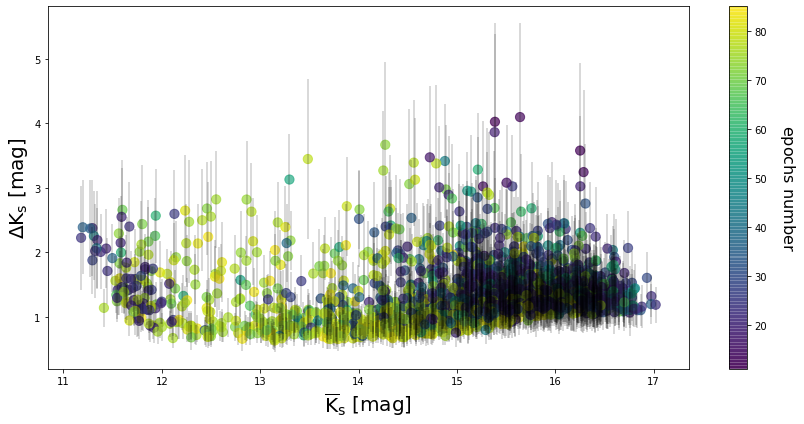

In [57]:
plt.figure(figsize=(12,6))

plt.errorbar(df['mean_Ks'], df['ampl'],df['devstd'],0,',', linestyle='none', ecolor='black', alpha=0.2,capsize=0, ms=0)
sc=plt.scatter(df['mean_Ks'],df['ampl'],c=df['epoch'], s=85, alpha=0.7)

fz=10
fontsize = 20

#legend
cbar = plt.colorbar(sc)
cbar.set_label(r'${ \rm epochs\ number }$', rotation=270, fontsize=16, labelpad=30)

plt.xlabel(r'${\rm \overline{K}_s\ [mag]}$',fontsize=fontsize)
plt.ylabel(r'${\rm \Delta K_{s}\ [mag] }$',fontsize=fontsize)
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)

#plt.yscale('log')

plt.tight_layout()
#plt.savefig("BaelysDiagram.jpg", format='jpg',dpi=100)
plt.show()

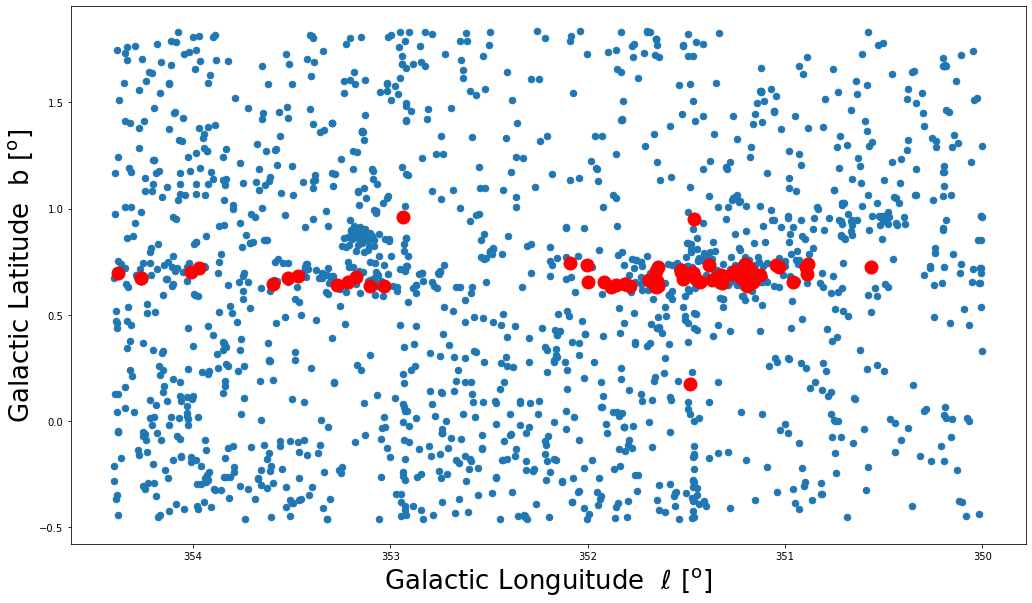

In [65]:
plt.figure(figsize=(14,8))

l,b = ReadCords(df['Ra'],df['Dec'],gal=True,Ndecimales=7)

l_over, b_over = ReadCords(df_overplotted['Ra_1'],df_overplotted['Dec_1'],gal=True,Ndecimales=7)

plt.plot(l,b,'.', ms=13)
plt.plot(l_over, b_over,'ro', ms=13)
plt.tight_layout()
plt.xlabel(r'${\rm Galactic\ Longuitude\ \ \ell\ [^{o}]}$',fontsize=26) 
plt.ylabel(r'${\rm Galactic\ Latitude\ \ b\ [^{o}]}$'     ,fontsize=26) 
plt.gca().invert_xaxis()
plt.show()

Alrededor de 1800 fuentes candidatas, y sobredensidades prometedoras. Ahora veremos la distribución de épocas de estas fuentes:

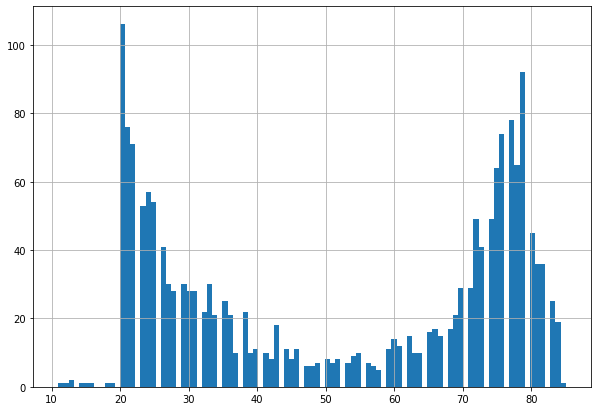

In [41]:
plt.figure(figsize=(10,7))
hist = df['epoch'].hist(bins=nbins(df['epoch']))

Existe una alta presencia de fuentes con bajo numero de observaciones, que parecieran tener un punto de inflexión en epochs=50. Haremos el corte en ese valor y volveremos a plotear la distribución espacial.  

In [61]:
highEpochNumber = df.loc[(df["epoch"] >= 50)]

highEpochNumber["epoch"].size

957

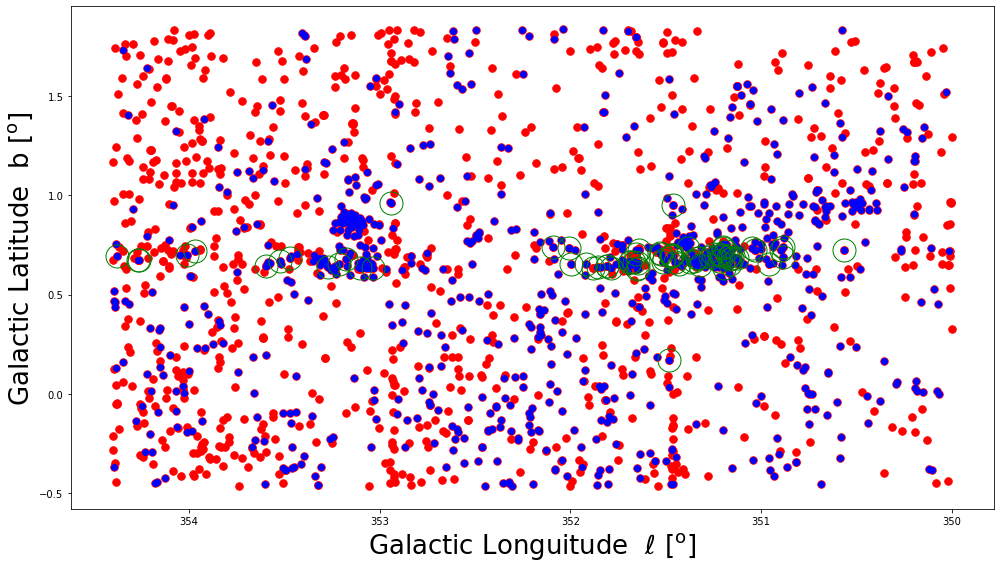

In [64]:
plt.figure(figsize=(14,8))

l_50,b_50 = ReadCords(highEpochNumber['Ra'],highEpochNumber['Dec'],gal=True,Ndecimales=7)

plt.plot(l,b,'r.', ms=15)
plt.plot(l_50,b_50,'b.', ms=12)
plt.plot(l_over, b_over,'go', ms=23, mfc='none')
plt.gca().invert_xaxis()
plt.xlabel(r'${\rm Galactic\ Longuitude\ \ \ell\ [^{o}]}$',fontsize=26) 
plt.ylabel(r'${\rm Galactic\ Latitude\ \ b\ [^{o}]}$'     ,fontsize=26) 
plt.tight_layout()
plt.show()

## Visualizar series de tiempo superpuestas:

existen 75 fuentes que fueron observadas e indentificadas por separado por el mismo método y diferentes tiles. Primero haremos algunas comparaciones básicas, como amplitud, magnitud promedio e índice eta:


In [67]:
df_overplotted = pd.read_csv(path_catalogs+'/Irregular_catalog_SFR3_superposed_21Sep2021.csv', sep=',')

df_overplotted['mean_Ks_1'].size

df_overplotted.head()

#df_overplotted.head()

,Ra_1,Dec_1,catname_1,epoch_1,ampl_1,mean_Ks_1,meanerr_1,devstd_1,meanstd_1,Eta_1,...,devstd_2,meanstd_2,Eta_2,J_2,K_2,logchi2_2,kurt_2,skewness_2,tileID_2,Separation
0,261.894510,-33.631688,261.8945103-33.63168788.lc,62,2.191,14.808,0.042,0.655,22.615,0.373,...,0.618,24.314,0.566,5.023,0.857,4.113,8738.995,-302.896,b343,0.146415
1,261.349514,-34.456369,261.34951386-34.45636905.lc,72,2.106,16.237,0.025,0.394,41.223,0.695,...,0.500,32.360,0.718,2.792,0.724,3.518,5663.782,-355.182,b343,0.285483
2,261.455182,-34.296707,261.4551824-34.2967073.lc,76,1.654,15.481,0.025,0.424,36.549,0.870,...,0.521,29.936,0.544,4.399,0.862,3.941,6023.715,-189.750,b343,0.087457
3,261.404152,-34.313533,261.40415233-34.31353325.lc,77,1.578,14.882,0.023,0.406,36.623,0.585,...,0.354,41.969,0.639,3.026,0.805,3.360,2245.104,-67.613,b343,0.028725
4,261.396527,-34.399949,261.3965266-34.39994898.lc,76,1.538,15.520,0.025,0.416,37.342,0.837,...,0.320,48.653,0.650,2.515,0.833,2.885,726.262,-5.729,b343,0.301681


Text(0, 0.5, '${\\rm \\eta }$')

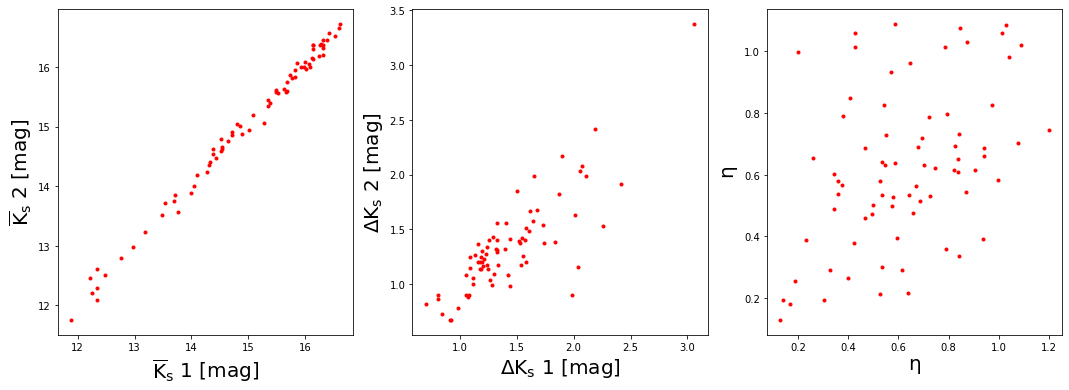

In [74]:
plt.figure(figsize=(18,6))

fz=20

plt.subplot(131)
plt.plot(df_overplotted['mean_Ks_1'],df_overplotted['mean_Ks_2'],'r.')
plt.xlabel(r'${\rm \overline{K}_s \ 1 \ [mag]}$',fontsize=fz) 
plt.ylabel(r'${\rm \overline{K}_s \ 2 \ [mag]}$',fontsize=fz) 

plt.subplot(132)
plt.plot(df_overplotted['ampl_1'],df_overplotted['ampl_2'],'r.')
plt.xlabel(r'${\rm \Delta K_{s}\ 1\ [mag]}$',fontsize=fz) 
plt.ylabel(r'${\rm \Delta K_{s}\ 2\ [mag]}$',fontsize=fz) 

plt.subplot(133)
plt.plot(df_overplotted['Eta_1'],df_overplotted['Eta_2'],'r.')
plt.xlabel(r'${\rm \eta }$',fontsize=fz) 
plt.ylabel(r'${\rm \eta }$',fontsize=fz) 

Habría que estimar la correlacion de la amplitud usando una regresión lineal para poder comparar. Agregar todos los índices y sus incertezas para graficar todos los resultados en un plot de regresión lineal :D

Ahora, es necesario visualizar las fuentes juntando las series de tiempo de estrellas overplotted:

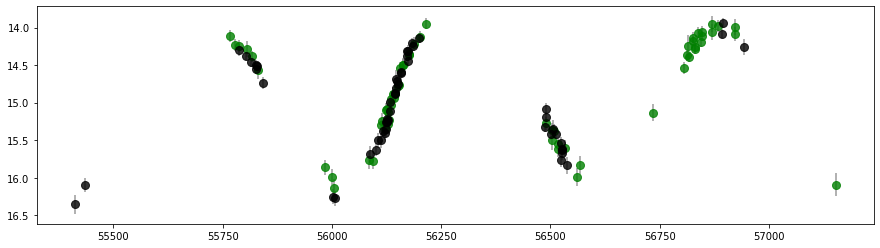

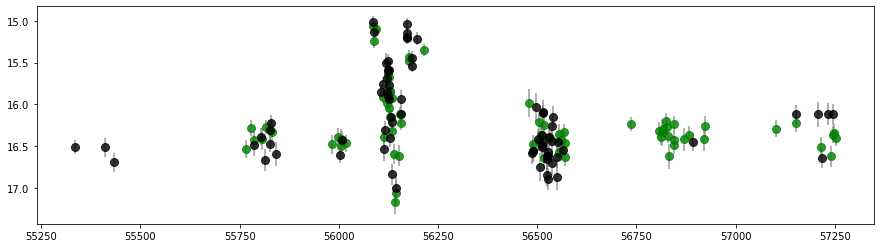

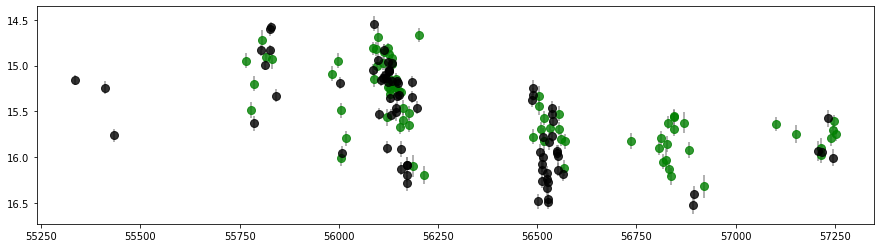

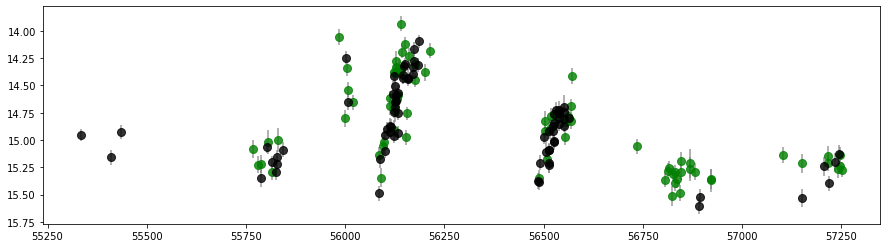

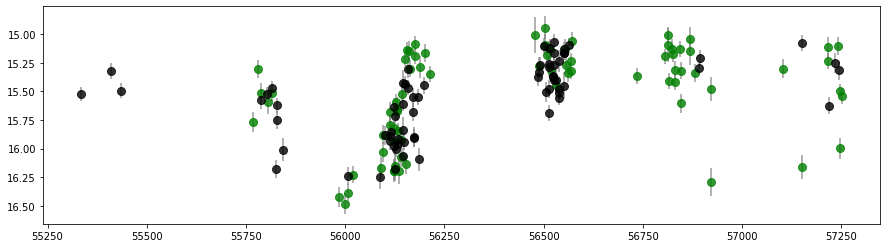

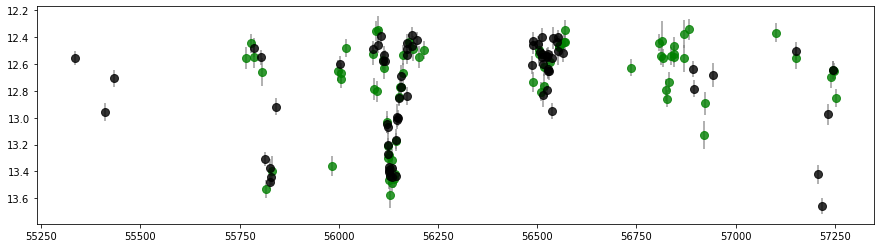

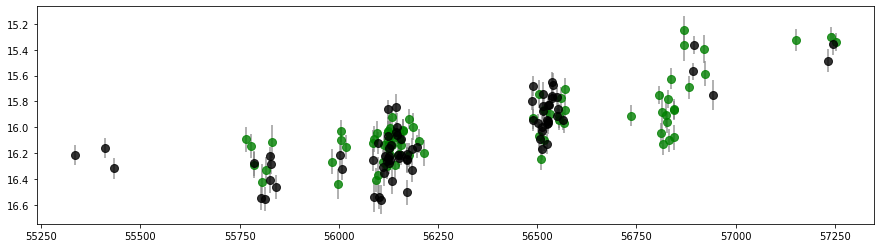

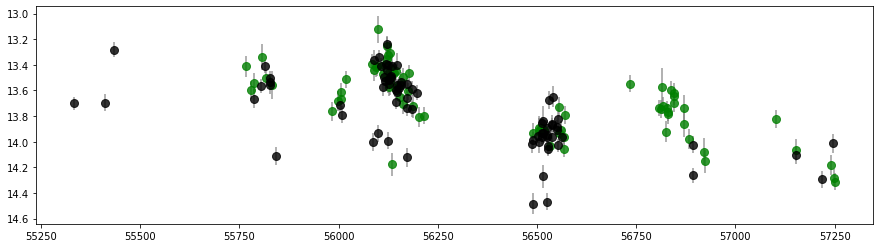

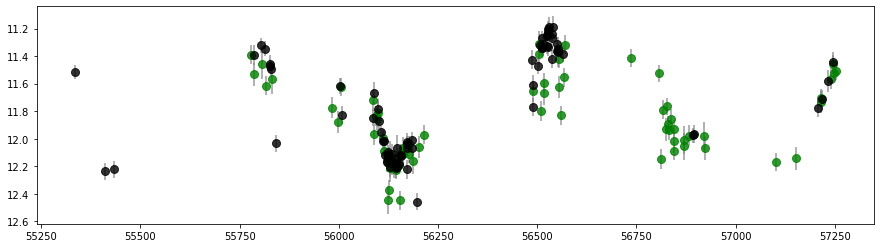

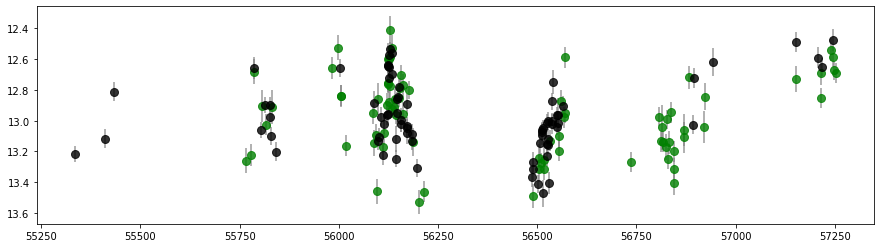

In [87]:
#for i in range(df_overplotted['mean_Ks_1'].size,10):
for i in range(0,10):
    cat_1, cat_2 = df_overplotted['catname_1'].iloc[i],df_overplotted['catname_2'].iloc[i]
    tileID1, tileID2 = df_overplotted['tileID_1'].iloc[i],df_overplotted['tileID_2'].iloc[i]
    
    #los datos a los tiles tienes diferentes caminos, así que hay que especificarlos:
    
    if tileID1 == 'b310' or tileID1 =='b343':
        path_1='/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/'+tileID1+'_data/Amplitude_Candidates/'
    else:
        path_1='/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/'+tileID1+'_data/Amplitude_Candidates/'
        
    if tileID2 == 'b310' or tileID2 =='b343':
        path_2='/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/'+tileID2+'_data/Amplitude_Candidates/'
    else:
        path_2='/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/'+tileID2+'_data/Amplitude_Candidates/'
    
    lc1 = np.genfromtxt(path_1+cat_1)
    mjd1, mag1, err1 = lc1[:,0], lc1[:,1], lc1[:,2]
    
    lc2 = np.genfromtxt(path_2+cat_2)
    mjd2, mag2, err2 = lc2[:,0], lc2[:,1], lc2[:,2]
    
    plt.figure(figsize=(15,4))
    plt.errorbar(mjd1, mag1, err1,0, 'go', ecolor='gray', alpha=0.8, ms=8)
    plt.errorbar(mjd2, mag2, err2,0, 'ko', ecolor='gray', alpha=0.8, ms=8)
    plt.gca().invert_yaxis()
    plt.show()

